Load libraries

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize

from sklearn.metrics import jaccard_score

Define Constants and stuff

In [2]:
seed = 4
np.random.seed = seed
random.seed(seed)
DATA_TEST = "./datasets/KolektorSDD2/test/"
test_ids = next(os.walk(os.path.join(DATA_TEST, "images/")))[2]

IMAGE_HEIGHT =  192
IMAGE_WIDTH = 64
IMAGE_CHANNELS = 3

Load Test images

In [3]:

# test images
test_images = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
test_masks = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = DATA_TEST
    img = imread(path + '/images/' + id_ )[:,:,:IMAGE_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    test_images[n] = img
    
    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]

    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0     
    mask = np.where(mask > 0.5, 1.0, 0.0) 
     
    test_masks[n] = mask 


Resizing test images


100%|██████████| 1004/1004 [00:30<00:00, 33.29it/s]


In [4]:
# # test images
# test_images_big = np.zeros((len(test_ids), IMAGE_HEIGHT*2, IMAGE_WIDTH*2, IMAGE_CHANNELS), dtype=np.float16)
# test_masks_big = np.zeros((len(test_ids), IMAGE_HEIGHT*2, IMAGE_WIDTH*2), dtype=np.float16)
# sizes_test_big = []

# print('Resizing test images') 
# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#     path = DATA_TEST
#     img = imread(path + '/images/' + id_ )[:,:,:IMAGE_CHANNELS]
#     sizes_test_big.append([img.shape[0], img.shape[1]])
#     img = resize(img, (IMAGE_HEIGHT*2, IMAGE_WIDTH*2), mode='constant', preserve_range=True)
#     img /= 255.0
#     test_images_big[n] = img
    
#     mask = np.zeros((IMAGE_HEIGHT*2, IMAGE_WIDTH*2, 1), dtype=bool)
#     mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
#     mask = imread(mask_file)[:,:]

#     mask = resize(mask, (IMAGE_HEIGHT*2, IMAGE_WIDTH*2), mode='constant', preserve_range=True)
#     mask /= 255.0     
#     mask = np.where(mask > 0.5, 1.0, 0.0) 
     
#     test_masks_big[n] = mask 

Resizing test images


100%|██████████| 1004/1004 [00:39<00:00, 25.49it/s]


Load model

In [5]:
model1 = tf.keras.models.load_model('./trainedModels/thirdWorkingSegmentation.h5')
model2 = tf.keras.models.load_model('./trainedModels/overnightSegmentation.h5')
model3 = tf.keras.models.load_model('./trainedModels/overnightSegmentationBigImages.h5')
model4 = tf.keras.models.load_model('./trainedModels/overnightSegmentationBigImages2.h5')

Prediction

In [6]:
Y_pred1 = model1.predict(test_images)
Y_pred2 = model2.predict(test_images)
Y_pred3 = model3.predict(test_images)
Y_pred4 = model4.predict(test_images)

32/32 [==============================] - 12s 200ms/step


Calculate IoU

In [7]:
# IoU = jaccard_score(test_ids, Y_pred)

IoU over Threshold

In [8]:
true_masks_flat = test_masks.reshape(test_masks.shape[0], -1)
# true_masks_big_flat = test_masks_big.reshape(test_masks_big.shape[0], -1)
Y_pred1_flat = Y_pred1.reshape(Y_pred1.shape[0], -1)
Y_pred2_flat = Y_pred2.reshape(Y_pred2.shape[0], -1)
Y_pred3_flat = Y_pred3.reshape(Y_pred3.shape[0], -1)
Y_pred4_flat = Y_pred4.reshape(Y_pred4.shape[0], -1)

threshold_values = np.linspace(0, 1, 100)
jaccard_scores1 = []
jaccard_scores2 = []
jaccard_scores3 = []
jaccard_scores4 = []
for threshold in threshold_values:
    y_pred_binary1 = (Y_pred1 >= threshold).astype(int)
    y_pred_binary2 = (Y_pred2 >= threshold).astype(int)
    y_pred_binary3 = (Y_pred3 >= threshold).astype(int)
    y_pred_binary4 = (Y_pred4 >= threshold).astype(int)
    pred_masks_binary_flat1 = y_pred_binary1.reshape(y_pred_binary1.shape[0], -1)
    pred_masks_binary_flat2 = y_pred_binary2.reshape(y_pred_binary2.shape[0], -1)
    pred_masks_binary_flat3 = y_pred_binary3.reshape(y_pred_binary3.shape[0], -1)
    pred_masks_binary_flat4 = y_pred_binary4.reshape(y_pred_binary4.shape[0], -1)
    jaccard_scores1.append(jaccard_score(true_masks_flat, pred_masks_binary_flat1, average="micro"))
    jaccard_scores2.append(jaccard_score(true_masks_flat, pred_masks_binary_flat2, average="micro"))
    jaccard_scores3.append(jaccard_score(true_masks_flat, pred_masks_binary_flat3, average="micro"))
    jaccard_scores4.append(jaccard_score(true_masks_flat, pred_masks_binary_flat4, average="micro"))
    # jaccard_scores3.append(jaccard_score(true_masks_big_flat, pred_masks_binary_flat3, average="micro"))


print('Best threshold for model1: ', threshold_values[np.argmax(jaccard_scores1)]
        , ' with Jaccard score: ', jaccard_scores1[np.argmax(jaccard_scores1)])
print('Best threshold for model2: ', threshold_values[np.argmax(jaccard_scores2)]
        , ' with Jaccard score: ', jaccard_scores2[np.argmax(jaccard_scores2)])
print('Best threshold for model3: ', threshold_values[np.argmax(jaccard_scores3)]
        , ' with Jaccard score: ', jaccard_scores3[np.argmax(jaccard_scores3)])
print('Best threshold for model4: ', threshold_values[np.argmax(jaccard_scores4)]
        , ' with Jaccard score: ', jaccard_scores4[np.argmax(jaccard_scores4)]) 
# for threshold in threshold_values:
#     y_pred_binary = (Y_pred >= threshold).astype(int)
#     pred_masks_binary_flat = y_pred_binary.reshape(y_pred_binary.shape[0], -1)
#     jaccard_scores1.append(jaccard_score(true_masks_flat, pred_masks_binary_flat, average="micro"))



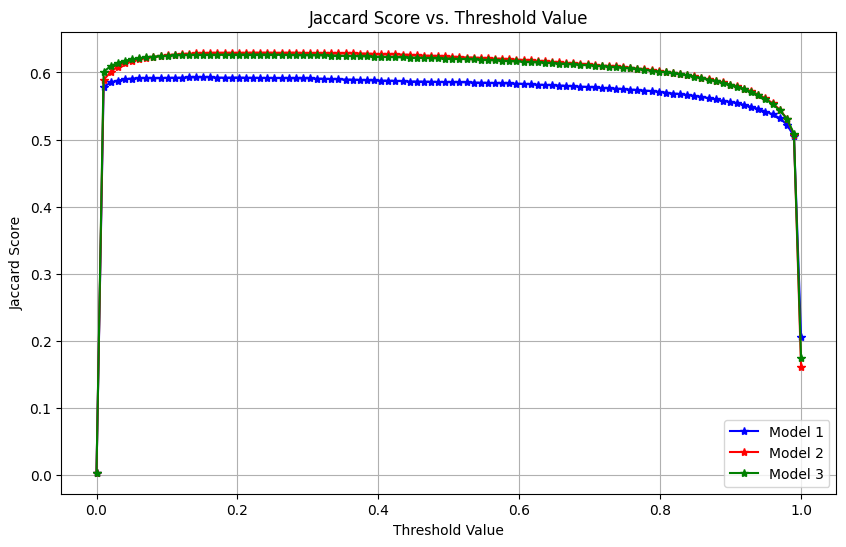

In [21]:
#Plotting

plt.figure(figsize=(10, 6))
plt.plot(threshold_values, jaccard_scores1, color='blue', marker='*', linestyle='-', label='Model 1')
plt.plot(threshold_values, jaccard_scores2, color='red', marker='*', linestyle='-', label='Model 2')
plt.plot(threshold_values, jaccard_scores3, color='green', marker='*', linestyle='-', label='Model 3')
plt.plot(threshold_values, jaccard_scores4, color='purple', marker='*', linestyle='-', label='Model 4')
plt.title('Jaccard Score vs. Threshold Value')
plt.legend(loc="lower right")
plt.xlabel('Threshold Value')
plt.ylabel('Jaccard Score')

# plt.ylim(0.5, 0.7)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = model1
threshold = threshold_values[np.argmax(jaccard_scores1)]

test_masks_bin = np.array([1 if np.count_nonzero(element) != 0 else 0 for element in test_masks])

# Assuming you have 'test_labels' and 'binary_predictions'
# test_labels: True labels for the test set
# binary_predictions: Predictions made by the model (0 or 1)

Y_pred = model.predict(test_images)
Y_pred_bin_list = []
for val in Y_pred:
    if val > threshold:
        Y_pred_bin_list.append(1)
    else:
        Y_pred_bin_list.append(0)
Y_pred_bin = np.array(Y_pred_bin_list)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_masks_bin, Y_pred_bin)

# Display the confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Additional metrics
accuracy = accuracy_score(test_masks_bin, Y_pred_bin)
precision = precision_score(test_masks_bin, Y_pred_bin)
recall = recall_score(test_masks_bin, Y_pred_bin)
f1 = f1_score(test_masks_bin, Y_pred_bin)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")